# Data preparation

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

In [2]:
# Import data
file_path = "glass_data.csv"
headers = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
elements = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
glass_df = pd.read_csv(file_path, sep=',', decimal='.', header=None, names=headers, index_col=0)

In [3]:
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## Examnine data shape, entry errors and missing values

In [4]:
# Shape of data
glass_df.shape

(214, 10)

In [5]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


The description indicates that:
- The attributes are all numeric types. There are no data type entry errors.
- The number of instances is 214, which matches the number of attributes in each column. We deduce that there is no missing values in the dataset.


In [6]:
glass_df.groupby('Type').count()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
Type,,,,,,,,,
1,70,70,70,70,70,70,70,70,70
2,76,76,76,76,76,76,76,76,76
3,17,17,17,17,17,17,17,17,17
5,13,13,13,13,13,13,13,13,13
6,9,9,9,9,9,9,9,9,9
7,29,29,29,29,29,29,29,29,29


## Examine impossible values and outliers

We further detects impossible values and outliers in the dataset using boxplot. Here, the outliers are identified via IQR method. That means, a value is considered in outlier if it is outside the range of Q3-Q1 interquatile range. (ref)

Text(0.5, 0.98, 'Chemical element distribution in glass')

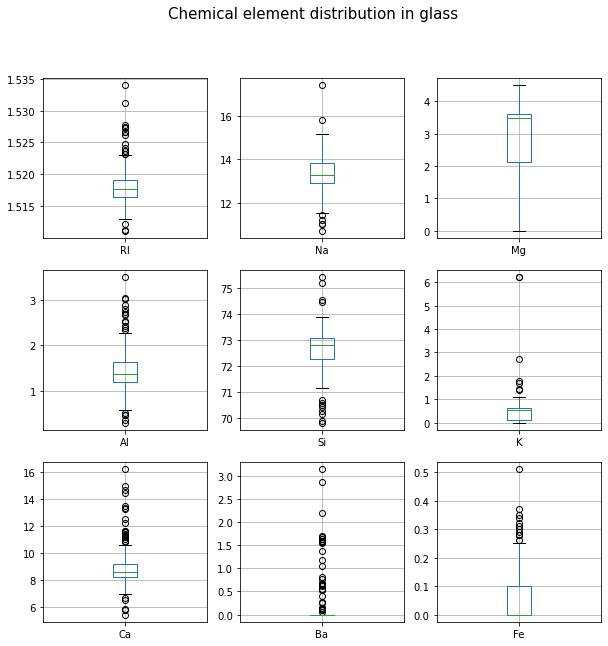

In [7]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i in range(len(headers)-1):
    a = glass_df.boxplot(column=headers[i], ax = axes.flatten()[i], figsize=(12,8))
fig.suptitle('Chemical element distribution in glass', fontsize=15)

From the boxplot, it can be observed that:
- Most of the figures have outliers, except for Magnesium.
- Boxplot figure is not applied well for Barium, so we cannot decide whether it has outliers or not. 
- Apart from Na and K, other elements have an excessive number of outliers.

However, we do not have enough evidence to consider the out of range values as outliers, since it could be a proportion indicating new source of glass. Thus, these outliers should be kept in the dataset.

For the elemental composition, the impossible values can be evaluated via two criteria:
- The weight percentage of the oxides should be >= 0 and < 100. 
- The sum of the weight percentages of the corresponding oxides in a glass composition should not be > 100%. It can be less than 100%, because there might be impurities in the composition. https://www.geeksforgeeks.org/percent-by-weight-formula/

For the refractive index, general glass fractive index cannot be negative.  https://www.asdlib.org/onlineArticles/elabware/thompson/Glass/Glass(RI)PFaculty.pdf

If a fragment (a row) does not satisfy these criteria, it should be eliminated from the dataset.

In [8]:
# Examine weight percentage of each element if it is out of range (0,100)
out_of_range = ((glass_df[elements] < 0) | (glass_df[elements] >= 100)).any()
out_of_range

Na    False
Mg    False
Al    False
Si    False
K     False
Ca    False
Ba    False
Fe    False
dtype: bool

In [9]:
# Examine the sum of weight percentage
weight_percentage_sum = glass_df[elements].sum(axis=1)
larger_than_100 = weight_percentage_sum.loc[weight_percentage_sum > 100.00001]
larger_than_100.name='Sum'
larger_than_100_df = glass_df[elements].loc[larger_than_100.index.tolist()]
larger_than_100_df.join(larger_than_100)

,Na,Mg,Al,Si,K,Ca,Ba,Fe,Sum
10,13.00,3.60,1.36,72.99,0.57,8.40,0.00,0.11,100.03
20,13.02,3.54,1.69,72.73,0.54,8.44,0.00,0.07,100.03
31,12.65,3.56,1.30,73.08,0.61,8.69,0.00,0.14,100.03
33,12.85,3.48,1.23,72.97,0.61,8.56,0.09,0.22,100.01
34,12.57,3.47,1.38,73.39,0.60,8.55,0.00,0.06,100.02
47,13.19,3.37,1.18,72.72,0.57,8.83,0.00,0.16,100.02
51,13.72,3.72,0.51,71.75,0.09,10.06,0.00,0.16,100.01
52,13.20,3.33,1.28,72.36,0.60,9.14,0.00,0.11,100.02
56,12.45,2.71,1.29,73.70,0.56,9.06,0.00,0.24,100.01
68,13.05,3.65,0.87,72.32,0.19,9.85,0.00,0.17,100.10


In [10]:
larger_than_100.count()

26

Observing the weight percentage summation, there are 26 rows having the summation larger than 100, with minor deviations from 0.01 to 0.1. These small variations can be explained by measurement and rounding errors. Hence, the values are acceptable, with the belief that it would introduce little error in the modelling stage.

In [11]:
# Examine the refractive index
(glass_df['RI'] < 0).any() 

False

There is no negative value of RI. However, it can be seen that the unit measurement of RI is different from other elements. Therefore, the dataset might need to be standardized prior the model building stage.

# Data exploration

## Data distribution

In [76]:
glass_df[glass_df.columns.difference(['Type'])].describe().round(2)

,Al,Ba,Ca,Fe,K,Mg,Na,RI,Si
count,214.00,214.00,214.00,214.00,214.00,214.00,214.00,214.00,214.00
mean,1.44,0.18,8.96,0.06,0.50,2.68,13.41,1.52,72.65
std,0.50,0.50,1.42,0.10,0.65,1.44,0.82,0.00,0.77
min,0.29,0.00,5.43,0.00,0.00,0.00,10.73,1.51,69.81
25%,1.19,0.00,8.24,0.00,0.12,2.11,12.91,1.52,72.28
50%,1.36,0.00,8.60,0.00,0.56,3.48,13.30,1.52,72.79
75%,1.63,0.00,9.17,0.10,0.61,3.60,13.82,1.52,73.09
max,3.50,3.15,16.19,0.51,6.21,4.49,17.38,1.53,75.41


Measures of central tendency:
- Si is the primary element in the glass composition, average accounting for 72.65%.
- The second and third element in glass concentration are Na and Ca, for the figures of 13% and 9% respectively. 
- Compared to Si, other elements have marginal content, with below 5% in average. 

Variability: The variability of the elements will be assessed by the coefficient of variation. By that, they are divided into two groups of low and high variability. This division supports the exploration in the following stage.

In [75]:
# Define the coefficient of variation 
def calc_cov(data, element):
    std = data[element].std()
    mean = data[element].mean()
    return ((std/mean) * 100)

threshold = 50
# Divide the chemical elements into two groups based on variability
high_var = dict()
low_var = dict()
for e in elements:
    cov = calc_cov(glass_df, e)
    if (cov > threshold):
        high_var[e] = cov
    else:
        low_var[e] = cov
print('---LOW VARIABILITY GROUP---')
for k,v in low_var.items():
    print(k + ': %.2f' %(v))
print('---HIGH VARIABILITY GROUP---')
for k,v in high_var.items():
    print(k + ': %.2f' %(v))

---LOW VARIABILITY GROUP---
Na: 6.09
Al: 34.55
Si: 1.07
Ca: 15.89
---HIGH VARIABILITY GROUP---
Mg: 53.73
K: 131.21
Ba: 284.05
Fe: 170.92


Text(0.5, 0.98, 'Chemical element distribution in glass')

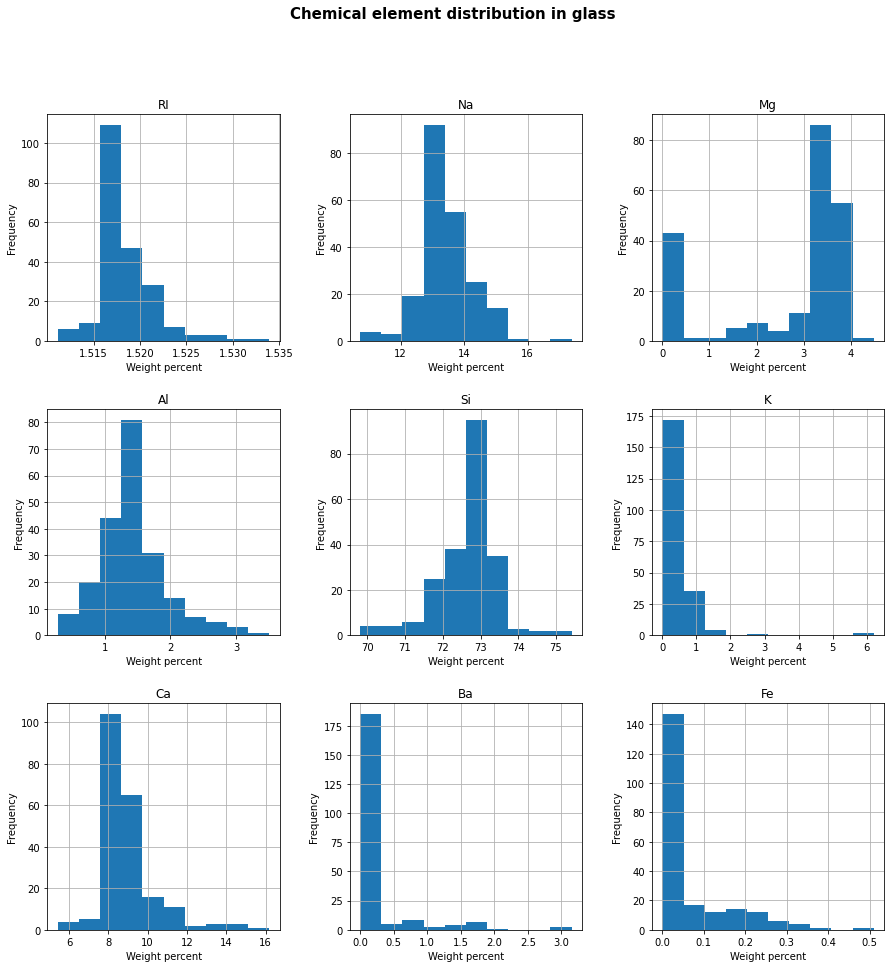

In [39]:
# Plot histogram for each column
fig, axes = plt.subplots(3,3, figsize=(15,15))

for i in range(len(headers) - 1):
    ax = axes.flatten()[i]
    glass_df.hist(column=headers[i], ax=ax)
    ax.set_title(headers[i])
    ax.set_xlabel('Weight percent')
    ax.set_ylabel('Frequency')
fig.suptitle('Chemical element distribution in glass', fontsize=15, fontweight='bold')

Text(0, 0.5, 'Number of samples')

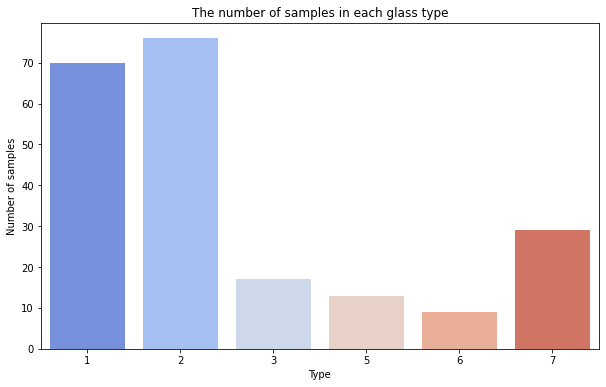

In [68]:
# Number of samples in each glass category
plt.figure(figsize=(10,6))
sns.countplot( data=glass_df, x='Type', palette='coolwarm')
plt.title('The number of samples in each glass type')
plt.ylabel('Number of samples')

## Bivariate analysis

### Find the potential correlation among features

We can start by spotting any strong correlation between the chemical elements, or a chemical elements vs refractive index.
- Ca and RI have the strong positive correlation at 0.8, while the others have a relatively low relationship with one another. We further investigate the relationship between Ca and RI.
- In terms of negative correlation, no pair of attributes have a correlation rate close to -1.

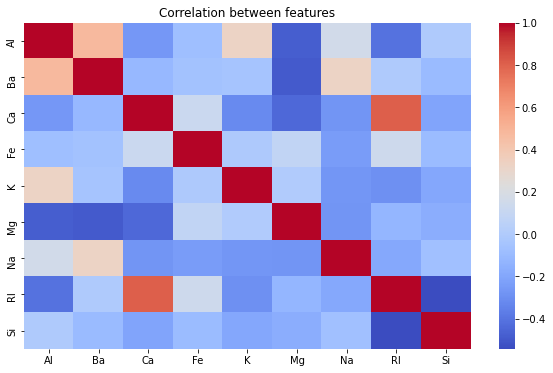

In [15]:
corr_matrix = glass_df[glass_df.columns.difference(['Type'])].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

### Hypothese 1: The distribution of elements in the low variability group is consistent amongst glass types

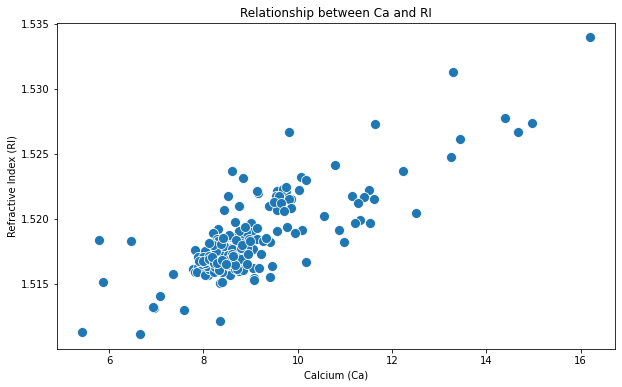

In [16]:
# Scatter plot of Ca vs RI
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ca', y='RI', data=glass_df, palette='Set1', s=100)
plt.title('Relationship between Ca and RI')
plt.xlabel('Calcium (Ca)')
plt.ylabel('Refractive Index (RI)')
plt.show()

It can be seen that higher Ca content is associated with higher RI. This indicates that Ca is likely to be a predictor for RI. By that, we can consider remove one of the attributes in the feature selection stage, so as to simplify the dataset and potential enhance the model performance.

### Hypothesis 2: All glass types have consistent range of refractive index (RI) values

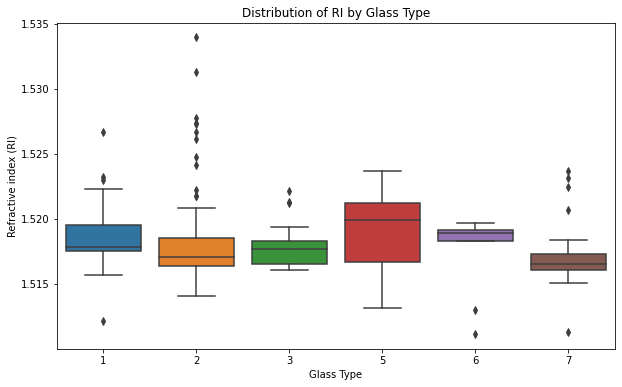

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='RI', data=glass_df)
plt.title('Distribution of RI by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Refractive index (RI)')
plt.show()

### Hypothese 3: There is no significant difference in the distribution of Fe amongst glass types

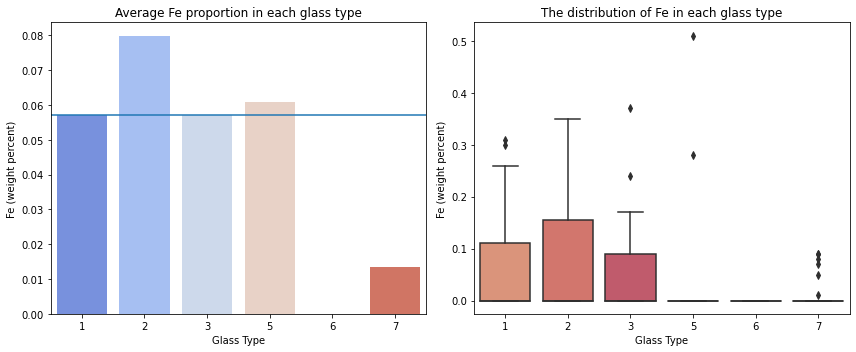

In [18]:
# Bar chart to show proportion of glass types with no Fe
fig, axes = plt.subplots(1,2, figsize=(12,5))
avg_fe = glass_df['Fe'].mean()

sns.barplot(ax=axes[0], x='Type', y='Fe', data=glass_df, ci=None, palette='coolwarm')
axes[0].set_title('Average Fe proportion in each glass type')
axes[0].set_xlabel('Glass Type')
axes[0].set_ylabel('Fe (weight percent)')
axes[0].axhline(avg_fe, label='Average Fe proportion')

sns.boxplot(ax=axes[1], x='Type', y='Fe', data=glass_df, palette='flare')
axes[1].set_title('The distribution of Fe in each glass type')
axes[1].set_xlabel('Glass Type')
axes[1].set_ylabel('Fe (weight percent)')
plt.tight_layout()
plt.show()

### Hypothese 4: The Ba proportion in different glass types is  relatively consistent

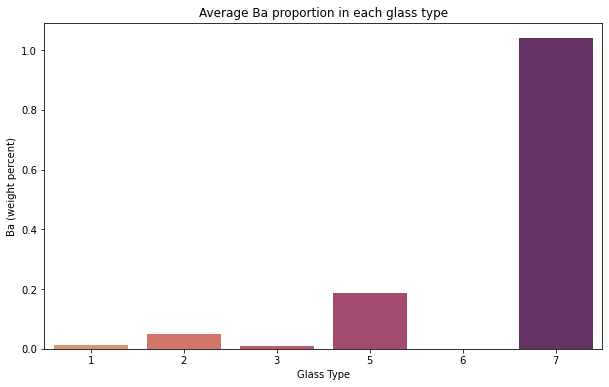

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Ba', data=glass_df, ci=None, palette='flare')
plt.title('Average Ba proportion in each glass type')
plt.xlabel('Glass Type')
plt.ylabel('Ba (weight percent)')
plt.show()

### Hypothese 5: There is a low variability in K proportion amongst glass types

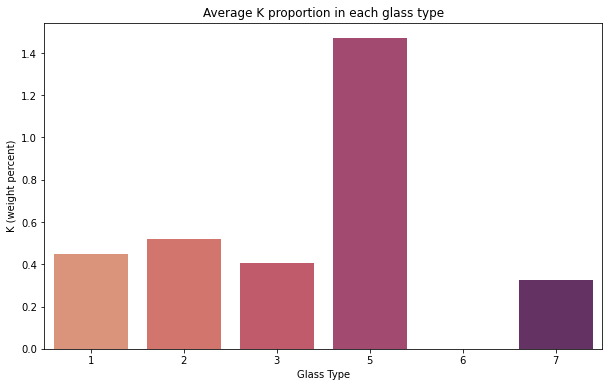

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='K', data=glass_df, ci=None, palette='flare')
plt.title('Average K proportion in each glass type')
plt.xlabel('Glass Type')
plt.ylabel('K (weight percent)')
plt.show()

### Hypothese:  The Si content is relatively consistent across all glass types

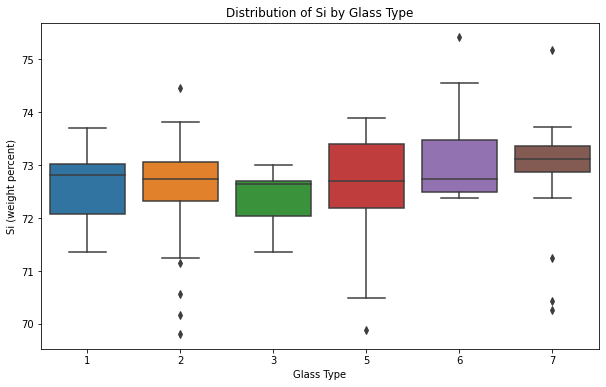

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Si', data=glass_df)
plt.title('Distribution of Si by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Si (weight percent)')
plt.show()

### Hypothese: The distribution of Al is consistent amongst all glass types

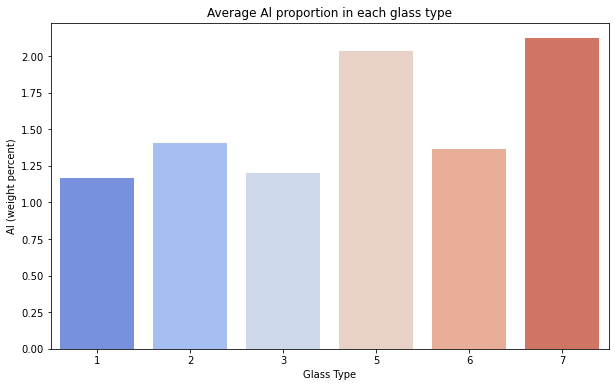

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Al', data=glass_df, ci=None, palette='coolwarm')
plt.title('Average Al proportion in each glass type')
plt.xlabel('Glass Type')
plt.ylabel('Al (weight percent)')
plt.show()

# Data modelling